# Spatial Temporal and Theoretical Benchmarking

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = Path("/datadrive/data")
run_dir = data_dir / "runs/complexity_AZURE/hs_064_0306_205514"
out_dir = run_dir / "cell_states"

In [3]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

st_data_dir = Path("/home/tommy/spatio_temporal/data")
points = load_latlon_points(st_data_dir)
static = xr.open_dataset(st_data_dir / "camels_static.nc")

# Input / Target Data

In [4]:
from scripts.cell_state.normalize import normalize_cstate
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable


if not (data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc").exists():
    cn = xr.open_dataset(out_dir / "cell_states.nc")
    norm_cs_data = normalize_cstate(cn, variable_str="c_n")
    norm_cs_data["station_id"] = [int(sid) for sid in norm_cs_data["station_id"]]
    if "date" in norm_cs_data.dims:
        norm_cs_data = norm_cs_data.rename({"date": "time"})

    if isinstance(norm_cs_data, xr.DataArray):
        norm_cs_data = norm_cs_data.to_dataset()

    if "c_n" in [v for v in norm_cs_data.data_vars]:
        norm_cs_data = norm_cs_data.rename({"c_n": "cell_state"})
        
    norm_cs_data.to_netcdf(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")
    
else:
    norm_cs_data = xr.open_dataset(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")
 

cs = dataset_dimensions_to_variable(
    ds=norm_cs_data, 
    variable="c_n",
    dimension_to_convert_to_variable_dim="dimension",
)

In [59]:
from scripts.cell_state.normalize import normalize_2d_dataset

filepath = data_dir / "SOIL_MOISTURE/interp_full_timeseries_esa_cci_sm.nc"
esa_ds = xr.open_dataset(filepath).drop("spatial_ref")
if not isinstance(esa_ds, xr.Dataset):
    esa_ds = esa_ds.to_dataset()

for var in esa_ds.data_vars:
    esa_ds[var] = normalize_2d_dataset(esa_ds, variable_str=var, per_basin=True)

Normalising each station: 100%|██████████| 670/670 [00:00<00:00, 753.62it/s]


In [6]:
print(esa_ds.data_vars)

Data variables:
    sm               (station_id, time) float32 nan nan nan ... 0.539 -0.1536
    7_day_smooth_sm  (station_id, time) float32 nan nan nan ... -0.5138 -0.3665


# Imports

In [7]:
from scripts.cell_state.sklearn_models import (
    init_sklearn_model,
    evaluate,
    create_analysis_dataset,
)
from scripts.cell_state.timeseries_dataset import TimeSeriesDataset, get_time_basin_aligned_dictionary

In [8]:
target_ds = esa_ds
input_ds = cs

train_start_date: pd.Timestamp = pd.to_datetime("1998-01-01")
train_end_date: pd.Timestamp = pd.to_datetime("2006-09-30")
test_start_date: pd.Timestamp = pd.to_datetime("2006-10-01")
test_end_date: pd.Timestamp =  pd.to_datetime("2009-10-01")
seq_length = 1
basin_dim = "station_id"
time_dim = "time"
target_var = "7_day_smooth_sm"
input_variables = [f"dim{i}" for i in np.arange(64)]

# train test split
target_data = target_ds.sel(time=slice(train_start_date, train_end_date))
input_data = input_ds.sel(time=slice(train_start_date, train_end_date))

test_target_data = target_ds.sel(time=slice(test_start_date, test_end_date))
test_input_data = input_ds.sel(time=slice(test_start_date, test_end_date))

train_dataset = TimeSeriesDataset(
    input_data=input_data,
    target_data=target_data,
    target_variable=target_var,
    input_variables=input_variables,
    seq_length=seq_length,
    basin_dim=basin_dim,
    time_dim=time_dim,
    desc="Creating Train Samples",
)

train = get_time_basin_aligned_dictionary(train_dataset)

Extracting Data: 100%|██████████| 8335/8335 [01:07<00:00, 123.33it/s]


Merging and reshaping arrays


In [277]:
from scripts.cell_state.sklearn_models import init_linear_model

In [278]:
np.random.choice

<function RandomState.choice>

In [9]:
# initalise the model 

random_seed = np.random.choice()
model = init_linear_model()

# fit the model 
model.fit(train["X"], train["y"].ravel())

SGDRegressor(alpha=0.01, early_stopping=True, loss='huber', n_iter_no_change=10,
             penalty='elasticnet')

# Comparison Performance

In [10]:
test_input_data = input_ds.sel(time=slice(test_start_date, test_end_date))
test_target_data = target_ds.sel(time=slice(test_start_date, test_end_date))

test_dataset = TimeSeriesDataset(
    input_data=test_input_data,
    target_data=test_target_data,
    target_variable=target_var,
    input_variables=input_variables,
    seq_length=seq_length,
    basin_dim=basin_dim,
    time_dim=time_dim,
    desc="Creating Test Samples",
)

test = get_time_basin_aligned_dictionary(test_dataset)

Creating Test Samples: 100%|██████████| 668/668 [00:05<00:00, 122.07it/s]


In [12]:
# make predictions from the fitted model 
preds, errors = evaluate(model, test)

Calculating Errors: 100%|██████████| 668/668 [00:08<00:00, 78.21it/s, 106001]


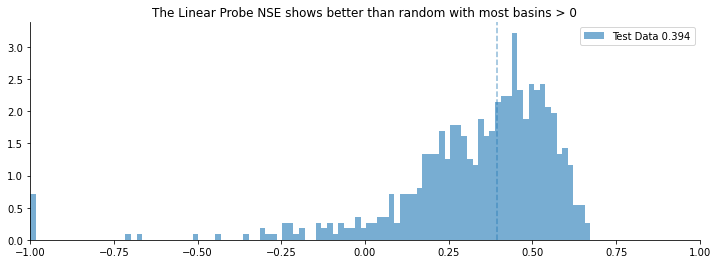

In [13]:
nse = errors["NSE"]

f, ax = plt.subplots(figsize=(12, 4))
ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"Test Data {nse.median().values:.3f}", alpha=0.6);
ax.axvline(nse.median(), color="C0", ls="--", alpha=0.5)

ax.set_xlim(-1, 1)
ax.legend()
ax.set_title("The Linear Probe NSE shows better than random with most basins > 0")
sns.despine()

# Spatial

In [ ]:
from scripts.cell_state.timeseries_dataset import shuffle_basin_dim

In [238]:
# shuffle the station_ids 
# https://stackoverflow.com/a/35646937/9940782

# np.random.Generator.permuted
# np.random.shuffle
from sklearn.utils import shuffle
from scripts.cell_state.timeseries_dataset import get_matching_dim

np.random.seed(10)

copy_sm = esa_ds.copy()
copy_sm["station_id"] = copy_sm["station_id"].astype(int)
copy_cs = cs.copy()
copy_cs["station_id"] = copy_cs["station_id"].astype(int)

# matching_stations
sm_sids, cs_sids = get_matching_dim(
    copy_sm, copy_cs, "station_id"
)
copy_sm = copy_sm.sel(station_id=sm_sids)
copy_cs = copy_cs.sel(station_id=cs_sids)

mapping = dict(zip(
    # original value: shuffled key
    copy_sm.station_id.values,
    shuffle(copy_sm.station_id.values),
))

inv_mapping = {
    # shuffled key: original value
    v: k for (k, v) in mapping.items()
}

In [226]:
shuffled_sm = copy_sm.copy()
shuffled_sm["station_id"] = [mapping[sid] for sid in shuffled_sm["station_id"].values]
assert shuffled_sm.station_id.values[0] == mapping[esa_ds.station_id.values[0]]

# shuffled_cs = copy_cs.copy()
# shuffled_cs["station_id"] = [mapping[sid] for sid in shuffled_cs["station_id"].values]
assert shuffled_sm.station_id.values[0] == mapping[cs.station_id.values[0]]

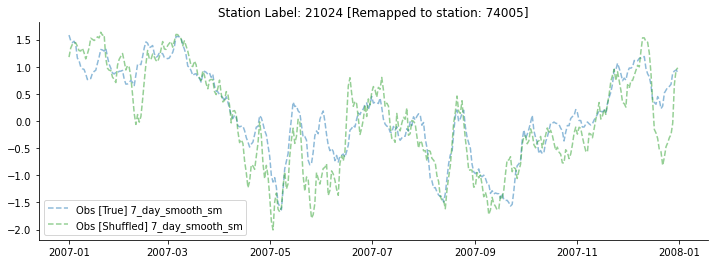

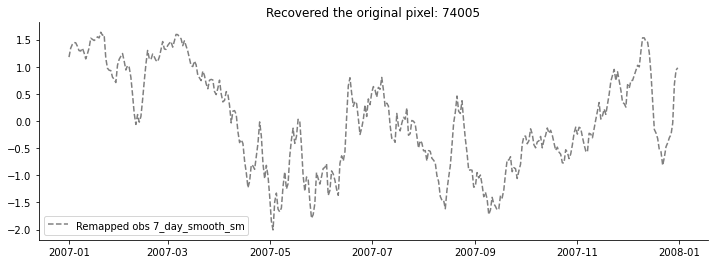

In [248]:
px = np.random.choice(shuffled_sm.station_id)

plot_var = "7_day_smooth_sm"
data = esa_ds.sel(time="2007", station_id=px)
shuff = shuffled_sm.sel(time="2007", station_id=px)
unshuffled_data = esa_ds.sel(time="2007", station_id=inv_mapping[px])

# plot_var = "dim0"
# data = cs.sel(time="2007", station_id=px)
# shuff = shuffled_cs.sel(time="2007", station_id=px)
# unshuffled_data = cs.sel(time="2007", station_id=mapping[px])

f, ax = plt.subplots(figsize=(12, 4))

ax.plot(data.time, data[plot_var], color="C0", ls="--", alpha=0.5, label=f"Obs [True] {plot_var}")
ax.plot(data.time, shuff[plot_var], color="C2", ls="--", alpha=0.5, label=f"Obs [Shuffled] {plot_var}")

ax.legend()
ax.set_title(f"Station Label: {data.station_id.values} [Remapped to station: {inv_mapping[px]}]")
sns.despine()

f, ax = plt.subplots(figsize=(12, 4))

ax.plot(data.time, unshuffled_data[plot_var], color="k", ls="--", alpha=0.5, label=f"Remapped obs {plot_var}")
ax.set_title(f"Recovered the original pixel: {inv_mapping[px]}")

ax.legend()
sns.despine()

In [178]:
from scripts.cell_state.sgd_model import create_train_test_datasets


shuff_train_dataset, shuff_test_dataset = create_train_test_datasets(
    target_var=target_var,
    input_variables=input_variables,
    target_ds=copy_sm,
    input_ds=shuffled_cs,
    train_start_date=train_start_date,
    train_end_date=train_end_date,
    test_start_date=test_start_date,
    test_end_date=test_end_date,
    subset_pixels=None,
    seq_length=1,
    basin_dim="station_id",
    time_dim="time",
)

shuff_train = get_time_basin_aligned_dictionary(shuff_train_dataset)
shuff_test = get_time_basin_aligned_dictionary(shuff_test_dataset)

Extracting Data: 100%|██████████| 8335/8335 [01:03<00:00, 131.08it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2145/2145 [00:16<00:00, 130.51it/s]

Merging and reshaping arrays


In [179]:
# initalise the model 
shuff_model = init_sklearn_model()

# fit the model 
shuff_model.fit(shuff_train["X"], shuff_train["y"].ravel())

# make predictions from the fitted model 
shuff_preds, shuff_errors = evaluate(shuff_model, shuff_test)

-- Epoch 1
Norm: 0.61, NNZs: 26, Bias: -0.008143, T: 1920232, Avg. loss: 0.051404
Total training time: 1.63 seconds.
-- Epoch 2
Norm: 0.60, NNZs: 24, Bias: -0.006463, T: 3840464, Avg. loss: 0.051379
Total training time: 3.49 seconds.
-- Epoch 3
Norm: 0.60, NNZs: 27, Bias: -0.008549, T: 5760696, Avg. loss: 0.051376
Total training time: 5.28 seconds.
-- Epoch 4
Norm: 0.60, NNZs: 25, Bias: -0.011017, T: 7680928, Avg. loss: 0.051374
Total training time: 7.12 seconds.
-- Epoch 5
Norm: 0.60, NNZs: 26, Bias: -0.009699, T: 9601160, Avg. loss: 0.051375
Total training time: 8.91 seconds.
-- Epoch 6
Norm: 0.60, NNZs: 25, Bias: -0.010178, T: 11521392, Avg. loss: 0.051376
Total training time: 10.75 seconds.
-- Epoch 7
Norm: 0.60, NNZs: 28, Bias: -0.007055, T: 13441624, Avg. loss: 0.051376
Total training time: 12.55 seconds.
-- Epoch 8
Norm: 0.60, NNZs: 27, Bias: -0.008189, T: 15361856, Avg. loss: 0.051374
Total training time: 14.34 seconds.
-- Epoch 9
Norm: 0.60, NNZs: 26, Bias: -0.003524, T: 17282

Calculating Errors: 100%|██████████| 668/668 [00:08<00:00, 80.35it/s, 106001]


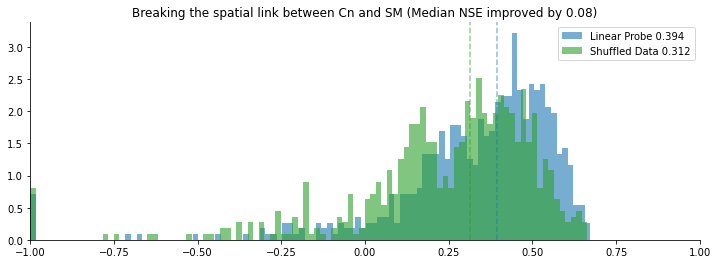

In [190]:
nse = errors["NSE"]
shuff_nse = shuff_errors["NSE"]

f, ax = plt.subplots(figsize=(12, 4))
ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"Linear Probe {nse.median().values:.3f}", alpha=0.6);
ax.axvline(nse.median(), color="C0", ls="--", alpha=0.5)

ax.hist(shuff_nse.where(shuff_nse > -1, -1), bins=100, density=True, label=f"Shuffled Data {shuff_nse.median().values:.3f}", alpha=0.6, color="C2");
ax.axvline(shuff_nse.median(), color="C2", ls="--", alpha=0.5)

ax.set_xlim(-1, 1)
ax.legend()

nse_diff = np.abs(float(shuff_nse.median()) - float(nse.median()))
ax.set_title(f"Breaking the spatial link between Cn and SM (Median NSE improved by {nse_diff:.2f})")
sns.despine()

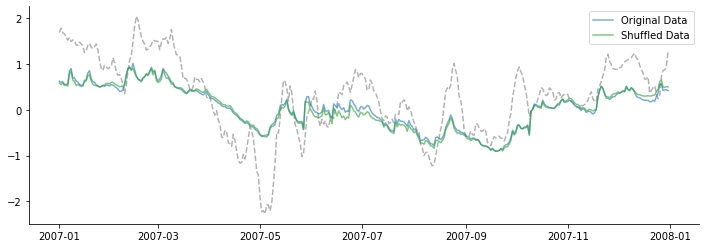

In [252]:
px = np.random.choice(preds.station_id.values)
time = "2007"

shuff = shuff_preds.sel(station_id=px, time=time)
data = preds.sel(station_id=px, time=time)

f, ax = plt.subplots(figsize=(12, 4))
# ax.plot(data.time, shuff.obs)
ax.plot(data.time, data.obs, color="k", ls="--", alpha=0.3)
ax.plot(data.time, data.sim, color="C0", ls="-", alpha=0.6, label="Original Data")
ax.plot(data.time, shuff.sim, color="C2", ls="-", alpha=0.6, label="Shuffled Data")
ax.legend()
sns.despine()

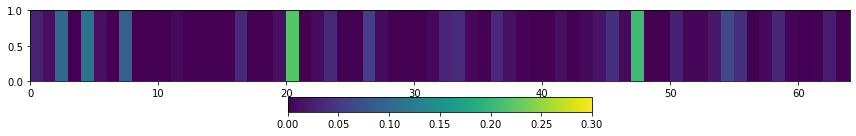

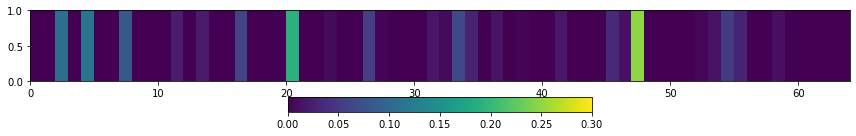

In [188]:
from scripts.cell_state.analysis import get_model_weights, plot_weights

w, b = get_model_weights(model)
s_w, s_b = get_model_weights(shuff_model)

# f, axs = plt.subplots(2, 1, figsize=(12, 2*2))
plot_weights(np.abs(w), kwargs={"vmin": 0.0, "vmax": 0.3}, ax=None)
ax = plot_weights(np.abs(s_w), kwargs={"vmin": 0.0, "vmax": 0.3}, ax=None)

# In Time

In [182]:
assert False, "Are you running both experiments now?"

AssertionError: Are you running both experiments now?

In [192]:
time_sm = esa_ds.copy()
time_cs = cs.copy()

In [254]:
# 180 day shift
shift_cs = time_cs.shift(time=180)
shift_sm = time_sm.shift(time=180)

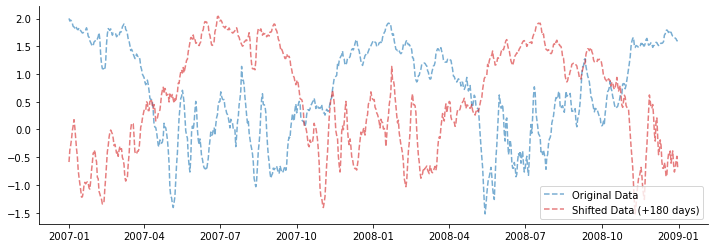

In [262]:
time = slice("2007", "2008")
px = np.random.choice(shift_sm.station_id.values)

data = esa_ds.sel(station_id=px, time=time)[target_var]
shift = shift_sm.sel(station_id=px, time=time)[target_var]

f, ax = plt.subplots(figsize=(12, 4))
ax.plot(data.time, data.values, color="C0", ls="--", alpha=0.6, label="Original Data")
ax.plot(data.time, shift.values, color="C3", ls="--", alpha=0.6, label="Shifted Data (+180 days)")

ax.legend()
sns.despine()

In [256]:
from scripts.cell_state.sgd_model import create_train_test_datasets


shift_train_dataset, shift_test_dataset = create_train_test_datasets(
    target_var=target_var,
    input_variables=input_variables,
    target_ds=shift_sm,
    input_ds=time_cs,
    train_start_date=train_start_date,
    train_end_date=train_end_date,
    test_start_date=test_start_date,
    test_end_date=test_end_date,
    subset_pixels=None,
    seq_length=1,
    basin_dim="station_id",
    time_dim="time",
)

shift_train = get_time_basin_aligned_dictionary(shift_train_dataset)
shift_test = get_time_basin_aligned_dictionary(shift_test_dataset)

Extracting Data: 100%|██████████| 8335/8335 [01:06<00:00, 124.80it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2145/2145 [00:16<00:00, 129.44it/s]

Merging and reshaping arrays


In [257]:
# initalise the model 
shift_model = init_sklearn_model()

# fit the model 
shift_model.fit(shift_train["X"], shift_train["y"].ravel())

# make predictions from the fitted model 
shift_preds, shift_errors = evaluate(shift_model, shift_test)

-- Epoch 1
Norm: 0.62, NNZs: 32, Bias: -0.029337, T: 1920232, Avg. loss: 0.053300
Total training time: 1.63 seconds.
-- Epoch 2
Norm: 0.62, NNZs: 32, Bias: -0.026457, T: 3840464, Avg. loss: 0.053265
Total training time: 3.41 seconds.
-- Epoch 3
Norm: 0.62, NNZs: 33, Bias: -0.026578, T: 5760696, Avg. loss: 0.053263
Total training time: 5.23 seconds.
-- Epoch 4
Norm: 0.62, NNZs: 33, Bias: -0.031075, T: 7680928, Avg. loss: 0.053260
Total training time: 7.00 seconds.
Convergence after 4 epochs took 7.17 seconds


Calculating Errors: 100%|██████████| 668/668 [00:08<00:00, 79.82it/s, 106001]


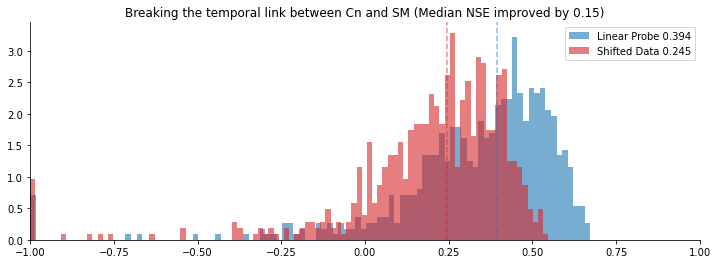

In [263]:
nse = errors["NSE"]
shift_nse = shift_errors["NSE"]

f, ax = plt.subplots(figsize=(12, 4))
ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"Linear Probe {nse.median().values:.3f}", alpha=0.6);
ax.axvline(nse.median(), color="C0", ls="--", alpha=0.5)

ax.hist(shift_nse.where(shift_nse > -1, -1), bins=100, density=True, label=f"Shifted Data {shift_nse.median().values:.3f}", alpha=0.6, color="C3");
ax.axvline(shift_nse.median(), color="C3", ls="--", alpha=0.5)

ax.set_xlim(-1, 1)
ax.legend()

nse_diff = np.abs(float(shift_nse.median()) - float(nse.median()))
ax.set_title(f"Breaking the temporal link between Cn and SM (Median NSE improved by {nse_diff:.2f})")
sns.despine()

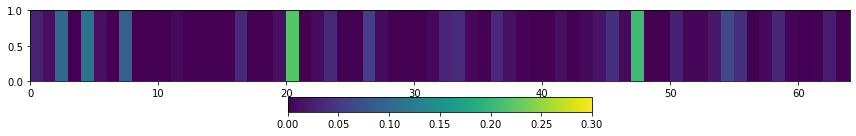

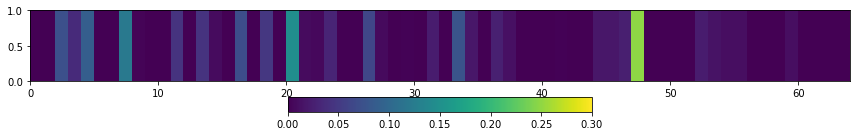

In [264]:
w, b = get_model_weights(model)
s_w, s_b = get_model_weights(shift_model)

# f, axs = plt.subplots(2, 1, figsize=(12, 2*2))
plot_weights(np.abs(w), kwargs={"vmin": 0.0, "vmax": 0.3}, ax=None)
ax = plot_weights(np.abs(s_w), kwargs={"vmin": 0.0, "vmax": 0.3}, ax=None)

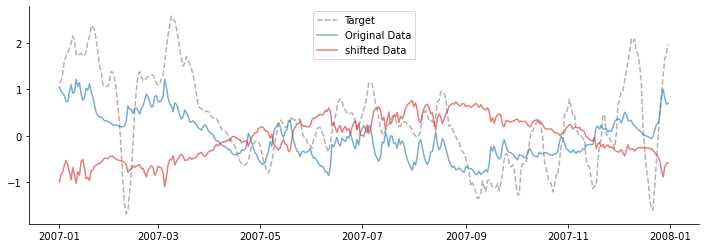

In [270]:
px = np.random.choice(preds.station_id.values)
time = "2007"

shift = shift_preds.sel(station_id=px, time=time)
data = preds.sel(station_id=px, time=time)

f, ax = plt.subplots(figsize=(12, 4))
# ax.plot(data.time, shuff.obs)
ax.plot(data.time, data.obs, color="k", ls="--", alpha=0.3, label="Target")
ax.plot(data.time, data.sim, color="C0", ls="-", alpha=0.6, label="Original Data")
ax.plot(data.time, shift.sim, color="C3", ls="-", alpha=0.6, label="shifted Data")
ax.legend()
sns.despine()

## Non linear model

In [ ]:
assert False, "non linear benchmark"

In [14]:
from sklearn.neural_network import MLPRegressor

In [15]:
hidden_sizes = [6, 32]
hs_str = "_".join([str(hs) for hs in hidden_sizes])
activation = "relu"

nl_model = MLPRegressor(
    hidden_layer_sizes=hidden_sizes,
    activation=activation,
    alpha=0.15,
    solver="adam",
    learning_rate="invscaling",
    random_state=100,
    max_iter=30,
    early_stopping=True,
    verbose=1,
    n_iter_no_change=3,
)

In [16]:
nl_model.fit(train["X"], train["y"].ravel())

Iteration 1, loss = 0.28616143
Validation score: 0.461824
Iteration 2, loss = 0.27473093
Validation score: 0.465847
Iteration 3, loss = 0.27311986
Validation score: 0.468981
Iteration 4, loss = 0.27244428
Validation score: 0.469920
Iteration 5, loss = 0.27232228
Validation score: 0.470095
Iteration 6, loss = 0.27217793
Validation score: 0.470561
Iteration 7, loss = 0.27206513
Validation score: 0.470563
Iteration 8, loss = 0.27199915
Validation score: 0.468580
Iteration 9, loss = 0.27196555
Validation score: 0.470220
Iteration 10, loss = 0.27187519
Validation score: 0.470458
Iteration 11, loss = 0.27190232
Validation score: 0.468868
Iteration 12, loss = 0.27188620
Validation score: 0.469177
Iteration 13, loss = 0.27182499
Validation score: 0.471923
Iteration 14, loss = 0.27185735
Validation score: 0.471890
Iteration 15, loss = 0.27179104
Validation score: 0.470021
Iteration 16, loss = 0.27178614
Validation score: 0.471617
Iteration 17, loss = 0.27175908
Validation score: 0.471349
Iterat

/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(alpha=0.15, early_stopping=True, hidden_layer_sizes=[6, 32],
             learning_rate='invscaling', max_iter=30, random_state=100,
             verbose=1)

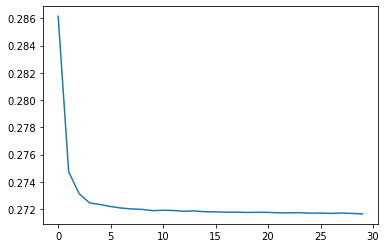

In [17]:
import matplotlib.pyplot as plt
plt.plot(nl_model.loss_curve_)

In [18]:
# make predictions from the fitted model 
nl_preds, nl_errors = evaluate(nl_model, test)

Calculating Errors: 100%|██████████| 668/668 [00:08<00:00, 78.89it/s, 106001]


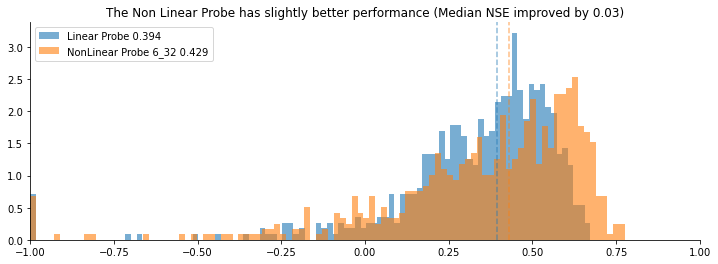

In [23]:
nse = errors["NSE"]
nl_nse = nl_errors["NSE"]

f, ax = plt.subplots(figsize=(12, 4))
ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"Linear Probe {nse.median().values:.3f}", alpha=0.6);
ax.axvline(nse.median(), color="C0", ls="--", alpha=0.5)

ax.hist(nl_nse.where(nl_nse > -1, -1), bins=100, density=True, label=f"NonLinear Probe {hs_str} {nl_nse.median().values:.3f}", alpha=0.6);
ax.axvline(nl_nse.median(), color="C1", ls="--", alpha=0.5)

ax.set_xlim(-1, 1)
ax.legend()

nse_diff = np.abs(float(nl_nse.median()) - float(nse.median()))
ax.set_title(f"The Non Linear Probe has slightly better performance (Median NSE improved by {nse_diff:.2f})")
sns.despine()

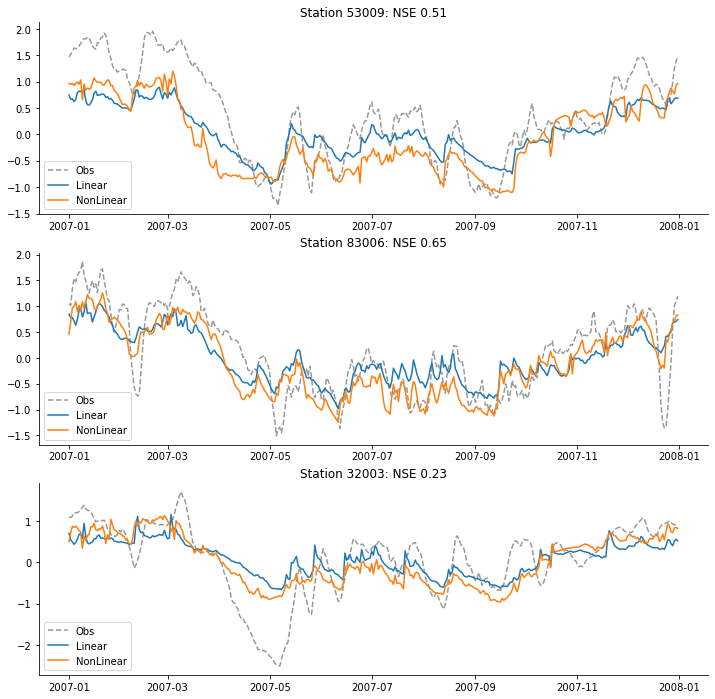

In [31]:
pixels = np.random.choice(preds.station_id.values, 3)
time = "2007"

f, axs = plt.subplots(len(pixels), 1, figsize=(12, 4*len(pixels)))

for ix, px in enumerate(pixels):
    ax = axs[ix]
    p = preds.sel(station_id=px, time=time)
    nl_p = nl_preds.sel(station_id=px, time=time)
    nse = float(errors.sel(station_id=px)["NSE"].values)

    ax.plot(p.time, p.obs, color="k", ls="--", label="Obs", alpha=0.4)
    ax.plot(p.time, p.sim, color="C0", ls="-", label="Linear")
    ax.plot(p.time, nl_p.sim, color="C1", ls="-", label="NonLinear")
    ax.set_title(f"Station {px}: NSE {nse:.2f}")
    ax.legend()
    sns.despine()